<a href="https://colab.research.google.com/github/AryanPatial/Aryan_INFO5731_Spring2025/blob/main/Patial_Aryan_Assignment_04_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment: 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) and BERTopic.**



**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100


NOTE: The output should be presented well to get **full points**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

**Dataset**: 20 Newsgroups dataset

**Dataset Link**: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

**Consider Random 2000 rows only**

Generate K=10 topics by using LDA and LSA,
then calculate coherence score and determine the optimized K value by the coherence score. Further, summarize and visualize each topics in you own words.


In [ ]:
# Uninstall and reinstall all key libraries
!pip uninstall -y numpy pandas gensim
!pip install numpy==1.26.4
!pip install pandas==2.1.4  # Compatible with NumPy 1.26.4
!pip install gensim==4.3.3


# After restart, run this
import pandas as pd
import numpy as np
import gensim

print("NumPy version:", np.__version__)  # Should be 1.26.4
print("Pandas version:", pd.__version__)  # Should be 2.1.4
print("Gensim version:", gensim.__version__)  # Should be 4.3.3

# Your imports
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
nltk.download('punkt')
nltk.download('stopwords')

NumPy version: 1.26.4
Pandas version: 2.1.4
Gensim version: 4.3.3


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Load the 20 Newsgroups dataset (training subset, remove metadata)
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
data = newsgroups.data

# Randomly select 2000 documents
random.seed(42)  # For reproducibility
sample_indices = random.sample(range(len(data)), 2000)
sampled_data = [data[i] for i in sample_indices]

# Preprocessing function
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Preprocess the sampled data
processed_docs = [preprocess_text(doc) for doc in sampled_data]

# Create dictionary and corpus for Gensim (used for coherence)
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [ ]:
# --- LSA (Latent Semantic Analysis) ---
# Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(doc) for doc in processed_docs])

# Apply LSA with K=10
lsa_model = TruncatedSVD(n_components=10, random_state=42)
lsa_topics = lsa_model.fit_transform(tfidf_matrix)

# Get top words for each LSA topic
terms = tfidf_vectorizer.get_feature_names_out()
lsa_top_words = []
for i, comp in enumerate(lsa_model.components_):
    top_terms = [terms[idx] for idx in comp.argsort()[-10:][::-1]]
    lsa_top_words.append(top_terms)

# Convert LSA topics to Gensim format for coherence
lsa_gensim_topics = [[word for word in topic] for topic in lsa_top_words]
lsa_coherence_model = CoherenceModel(topics=lsa_gensim_topics, texts=processed_docs, dictionary=dictionary, coherence='c_v')
lsa_coherence_score = lsa_coherence_model.get_coherence()

In [ ]:
# --- LDA (Latent Dirichlet Allocation) ---
# Vectorize the text using CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
count_matrix = count_vectorizer.fit_transform([' '.join(doc) for doc in processed_docs])

# Apply LDA with K=10
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(count_matrix)

# Get top words for each LDA topic
lda_terms = count_vectorizer.get_feature_names_out()
lda_top_words = []
for i, comp in enumerate(lda_model.components_):
    top_terms = [lda_terms[idx] for idx in comp.argsort()[-10:][::-1]]
    lda_top_words.append(top_terms)

# Calculate LDA coherence score
lda_gensim_topics = [[word for word in topic] for topic in lda_top_words]
lda_coherence_model = CoherenceModel(topics=lda_gensim_topics, texts=processed_docs, dictionary=dictionary, coherence='c_v')
lda_coherence_score = lda_coherence_model.get_coherence()

In [ ]:
# --- Optimize K by Coherence Score ---
k_values = range(5, 16)  # Test K from 5 to 15
lsa_coherence_scores = []
lda_coherence_scores = []

for k in k_values:
    # LSA
    lsa_model_k = TruncatedSVD(n_components=k, random_state=42)
    lsa_model_k.fit(tfidf_matrix)
    lsa_k_words = [[terms[idx] for idx in comp.argsort()[-10:][::-1]] for comp in lsa_model_k.components_]
    lsa_k_coherence = CoherenceModel(topics=lsa_k_words, texts=processed_docs, dictionary=dictionary, coherence='c_v').get_coherence()
    lsa_coherence_scores.append(lsa_k_coherence)

    # LDA
    lda_model_k = LatentDirichletAllocation(n_components=k, random_state=42)
    lda_model_k.fit(count_matrix)
    lda_k_words = [[lda_terms[idx] for idx in comp.argsort()[-10:][::-1]] for comp in lda_model_k.components_]
    lda_k_coherence = CoherenceModel(topics=lda_k_words, texts=processed_docs, dictionary=dictionary, coherence='c_v').get_coherence()
    lda_coherence_scores.append(lda_k_coherence)

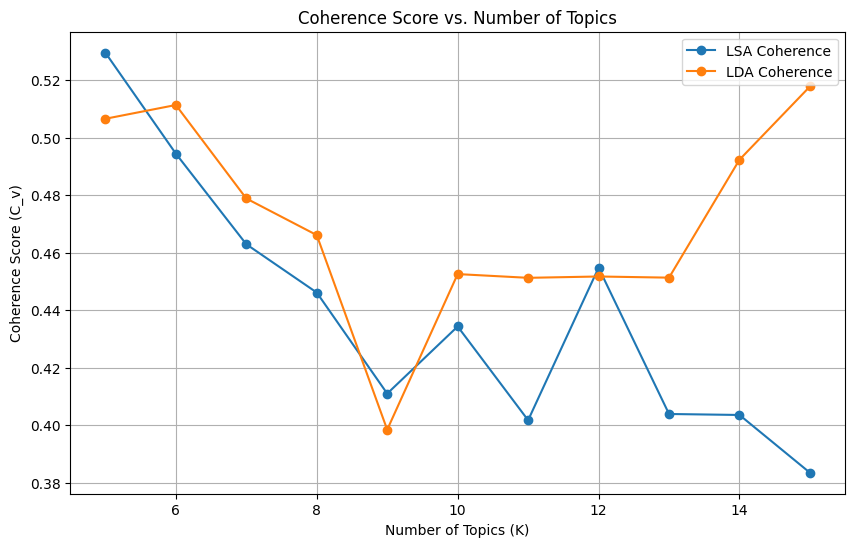

In [ ]:
# Plot coherence scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, lsa_coherence_scores, label='LSA Coherence', marker='o')
plt.plot(k_values, lda_coherence_scores, label='LDA Coherence', marker='o')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score (C_v)')
plt.title('Coherence Score vs. Number of Topics')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Determine optimal K
optimal_k_lsa = k_values[np.argmax(lsa_coherence_scores)]
optimal_k_lda = k_values[np.argmax(lda_coherence_scores)]
print(f"Optimal K for LSA: {optimal_k_lsa} (Coherence: {max(lsa_coherence_scores):.4f})")
print(f"Optimal K for LDA: {optimal_k_lda} (Coherence: {max(lda_coherence_scores):.4f})")

Optimal K for LSA: 5 (Coherence: 0.5296)
Optimal K for LDA: 15 (Coherence: 0.5178)


In [ ]:
# Define summarization functions with updated summaries
def summarize_lsa_topic(i, words):
    summaries = {
        0: "General conversational chatter, opinions, and casual exchanges.",
        1: "Computer systems, file management, and Windows/DOS usage.",
        2: "Philosophical or skeptical debates, possibly with specific user references.",
        3: "Religious discussions focusing on Christianity and belief.",
        4: "Encryption, privacy, and government tech policies (e.g., Clipper chip).",
        5: "Tech inquiries and discussions about encryption and communication.",
        6: "Mix of computer hardware (drives, SCSI) and religious mentions.",
        7: "Car-related talks mixed with casual conversation.",
        8: "Computer gaming and hardware (drives, DOS).",
        9: "Blend of encryption tech and miscellaneous hardware/games."
    }
    return summaries.get(i, "General discussion based on key terms.")

def summarize_lda_topic(i, words):
    summaries = {
        0: "Car enthusiasts discussing vehicles and performance.",
        1: "Space exploration mixed with computer and gaming terms.",
        2: "Tech and encryption with odd health/tobacco references.",
        3: "Political or social opinions and debates.",
        4: "Political talk, possibly Middle East or U.S. leadership.",
        5: "Religious discussions and personal opinions.",
        6: "Software interfaces and server-related topics.",
        7: "Historical or sports talk with controversial references.",
        8: "Computer help and general tech support queries.",
        9: "Windows software and file management discussions."
    }
    return summaries.get(i, "General discussion based on key terms.")

In [ ]:
# Summarize and print top words for LSA topics (K=10)
print("\n=== LSA Topics (K=10) ===")
for i, words in enumerate(lsa_top_words):
    print(f"Topic {i+1}: {', '.join(words)}")
    print(f"Summary: {summarize_lsa_topic(i, words)}")

# Summarize and print top words for LDA topics (K=10)
print("\n=== LDA Topics (K=10) ===")
for i, words in enumerate(lda_top_words):
    print(f"Topic {i+1}: {', '.join(words)}")
    print(f"Summary: {summarize_lda_topic(i, words)}")



=== LSA Topics (K=10) ===
Topic 1: dont, like, know, people, think, use, good, new, thanks, time
Summary: General conversational chatter, opinions, and casual exchanges.
Topic 2: thanks, windows, email, advance, files, drive, file, dos, using, use
Summary: Computer systems, file management, and Windows/DOS usage.
Topic 3: surrender, chastity, gebcadredslpittedu, njxp, skepticism, intellect, shameful, gordon, banks, soon
Summary: Philosophical or skeptical debates, possibly with specific user references.
Topic 4: god, thanks, know, advance, email, jesus, bible, church, believe, surrender
Summary: Religious discussions focusing on Christianity and belief.
Topic 5: encryption, use, government, window, key, law, files, windows, clipper, chip
Summary: Encryption, privacy, and government tech policies (e.g., Clipper chip).
Topic 6: thanks, email, new, advance, interested, encryption, government, information, chip, phone
Summary: Tech inquiries and discussions about encryption and communicat

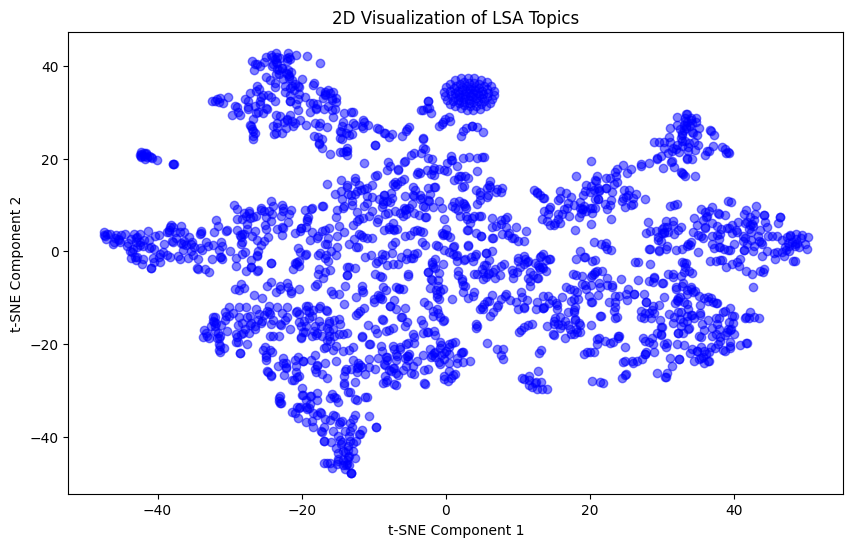

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Apply LSA with K=10 (already done in your code)
lsa_model = TruncatedSVD(n_components=10, random_state=42)
lsa_topics = lsa_model.fit_transform(tfidf_matrix)

# Reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
lsa_2d = tsne.fit_transform(lsa_topics)

# Plot the topics
plt.figure(figsize=(10, 6))
plt.scatter(lsa_2d[:, 0], lsa_2d[:, 1], c='blue', alpha=0.5)
plt.title("2D Visualization of LSA Topics")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


In [ ]:
!pip install pyLDAvis gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.2 MB/s eta 0:00:00


In [ ]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Create a Gensim dictionary and corpus
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Fit the LDA model (Gensim)
lda_gensim_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42)

# Visualize the topics using pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis = gensimvis.prepare(lda_gensim_model, corpus, dictionary)
pyLDAvis.display(vis)


# **BERTopic**

The following question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents.

Dataset from **assignment-3** (text dataset) .

> Dont use any custom datasets.


> Dataset must have 1000+ rows, no duplicates and null values



# **Question 2 (20 Points)**



Q2) **Generate K=10 topics by using BERTopic and then find optimal K value by the coherence score. Interpret each topic and visualize with suitable style.**

In [ ]:
# Install required libraries
!pip install bertopic pandas numpy matplotlib gensim

# Import libraries
import pandas as pd
import numpy as np
from bertopic import BERTopic
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print("Setup complete.")

Mounted at /content/drive
Setup complete.


In [ ]:
# Load the dataset from Google Drive
file_path = "/content/drive/My Drive/imdb_reviews_cleaned.csv"
df = pd.read_csv(file_path)



In [ ]:
print("Dataset Info:")
print(df.info())
print("\nShape:", df.shape)

# Check for null values in Cleaned_text
print("\nNull Values in Cleaned_text:")
print(df['Cleaned_text'].isnull().sum())

# Remove rows with null Cleaned_text (if any)
df = df.dropna(subset=['Cleaned_text'])
print("\nShape after removing nulls:", df.shape)



# Ensure 1000+ rows (proceed with warning if fewer)
if df.shape[0] < 1000:
    print(f"Warning: Dataset has {df.shape[0]} rows, less than 1000. Proceeding anyway.")

# Extract Cleaned_text column
docs = df['Cleaned_text'].tolist()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review        1000 non-null   object
 1   Cleaned_text  1000 non-null   object
 2   POS_Counts    1000 non-null   object
 3   NER_Counts    1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB
None

Shape: (1000, 4)

Null Values in Cleaned_text:
0

Shape after removing nulls: (1000, 4)


In [ ]:
# Initialize BERTopic with K=10
topic_model = BERTopic(nr_topics=10, verbose=True)

# Fit the model
topics, probs = topic_model.fit_transform(docs)

# Get topic info
topic_info = topic_model.get_topic_info()
print("\n=== Initial Topic Info (K=10) ===")
print(topic_info)

# Get the actual number of topics (excluding -1)
n_topics = len(topic_info) - 1  # Subtract 1 to exclude the -1 outlier topic
print(f"Number of valid topics generated: {n_topics}")

# Extract top words for interpretation only for valid topics
top_words = [topic_model.get_topic(i) for i in range(n_topics) if i != -1]
top_words = [[word[0] for word in topic] for topic in top_words if topic]  # Filter out False/None

# Check the extracted top words
print("\nTop words per topic:")
for i, words in enumerate(top_words):
    print(f"Topic {i+1}: {words}")

2025-04-06 23:29:43,653 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-04-06 23:31:06,619 - BERTopic - Embedding - Completed ✓
2025-04-06 23:31:06,620 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-06 23:31:09,005 - BERTopic - Dimensionality - Completed ✓
2025-04-06 23:31:09,006 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-06 23:31:09,051 - BERTopic - Cluster - Completed ✓
2025-04-06 23:31:09,052 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-06 23:31:09,203 - BERTopic - Representation - Completed ✓
2025-04-06 23:31:09,204 - BERTopic - Topic reduction - Reducing number of topics
2025-04-06 23:31:09,213 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-06 23:31:09,332 - BERTopic - Representation - Completed ✓
2025-04-06 23:31:09,335 - BERTopic - Topic reduction - Reduced number of topics from 21 to 10



=== Initial Topic Info (K=10) ===
   Topic  Count                              Name  \
0     -1    457        -1_movi_the_film_oppenheim   
1      0    140        0_oppenheim_film_the_nolan   
2      1     95             1_nolan_film_the_movi   
3      2     66              2_movi_time_the_like   
4      3     64                3_movi_the_film_it   
5      4     60              4_movi_watch_it_time   
6      5     45  5_film_nolan_christoph_oppenheim   
7      6     36            6_film_the_watch_great   
8      7     19             7_movi_imax_watch_the   
9      8     18            8_war_bomb_peopl_japan   

                                      Representation  \
0  [movi, the, film, oppenheim, nolan, like, one,...   
1  [oppenheim, film, the, nolan, robert, murphi, ...   
2  [nolan, film, the, movi, murphi, cillian, best...   
3  [movi, time, the, like, watch, stori, feel, fi...   
4  [movi, the, film, it, feel, make, oppenheim, c...   
5  [movi, watch, it, time, thi, the, stori, o

In [ ]:
# Interpret each topic based on top words, tailored to Oppenheimer movie reviews
print("\n=== Topic Interpretations (K=10) ===")
for i, words in enumerate(top_words):
    interpretation = f"Topic {i+1}: {', '.join(words[:10])}\n"
    if any(w in words for w in ["act", "actor", "perform", "murphi", "cillian", "downey", "rdj"]):
        interpretation += "Interpretation: Praise or critique of acting performances, likely focusing on Cillian Murphy or Robert Downey Jr."
    elif any(w in words for w in ["cinematographi", "visual", "shot", "screen", "imax"]):
        interpretation += "Interpretation: Discussion of cinematography, visuals, or IMAX experience."
    elif any(w in words for w in ["sound", "score", "music", "soundtrack", "loud"]):
        interpretation += "Interpretation: Focus on sound design, musical score, or audio impact."
    elif any(w in words for w in ["stori", "narr", "plot", "timelin", "nonlinear"]):
        interpretation += "Interpretation: Analysis of storytelling, narrative structure, or non-linear timelines."
    elif any(w in words for w in ["pace", "long", "hour", "runtime", "bore"]):
        interpretation += "Interpretation: Opinions on pacing, runtime length, or engagement level."
    elif any(w in words for w in ["bomb", "atom", "nuclear", "moral", "ethic"]):
        interpretation += "Interpretation: Exploration of the atomic bomb’s historical or ethical implications."
    elif any(w in words for w in ["nolan", "christoph", "direct", "filmmak"]):
        interpretation += "Interpretation: Commentary on Christopher Nolan’s direction or filmmaking style."
    else:
        interpretation += "Interpretation: Miscellaneous opinions, possibly general praise or criticism."
    print(interpretation)
    print()


=== Topic Interpretations (K=10) ===
Topic 1: oppenheim, film, the, nolan, robert, murphi, perform, bomb, christoph, movi
Interpretation: Praise or critique of acting performances, likely focusing on Cillian Murphy or Robert Downey Jr.

Topic 2: nolan, film, the, movi, murphi, cillian, best, oscar, perform, it
Interpretation: Praise or critique of acting performances, likely focusing on Cillian Murphy or Robert Downey Jr.

Topic 3: movi, time, the, like, watch, stori, feel, film, oppenheim, it
Interpretation: Analysis of storytelling, narrative structure, or non-linear timelines.

Topic 4: movi, the, film, it, feel, make, oppenheim, charact, stori, even
Interpretation: Analysis of storytelling, narrative structure, or non-linear timelines.

Topic 5: movi, watch, it, time, thi, the, stori, one, like, feel
Interpretation: Analysis of storytelling, narrative structure, or non-linear timelines.

Topic 6: film, nolan, christoph, oppenheim, the, best, one, work, it, time
Interpretation: Com

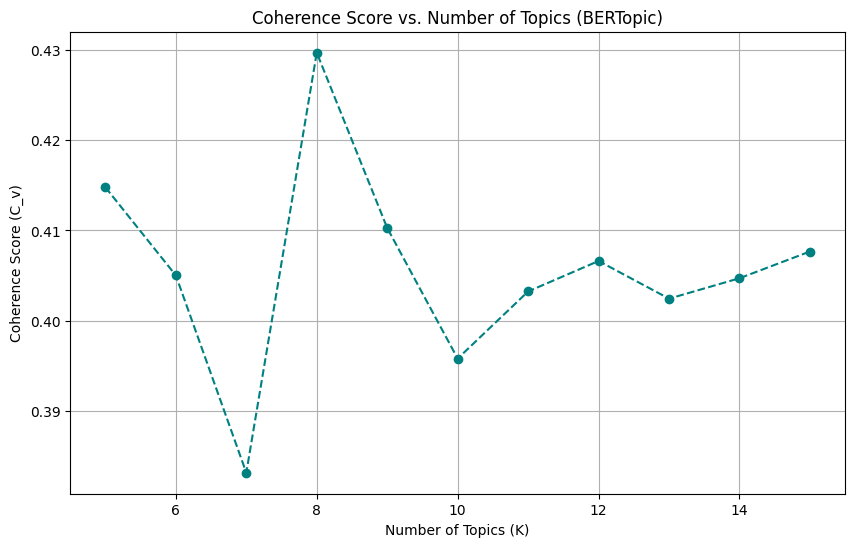

Optimal K: 8 (Coherence: 0.4297)


In [ ]:
# Preprocess docs for coherence (tokenized)
tokenized_docs = [doc.split() for doc in docs]
dictionary = Dictionary(tokenized_docs)

# Function to calculate coherence
def calculate_coherence(nr_topics):
    temp_model = BERTopic(nr_topics=nr_topics, verbose=False)
    topics, _ = temp_model.fit_transform(docs)
    temp_top_words = [temp_model.get_topic(i) for i in range(nr_topics) if i != -1]
    temp_top_words = [[word[0] for word in topic] for topic in temp_top_words if topic]  # Filter out False/None
    if not temp_top_words:  # Handle case where no valid topics are generated
        return 0.0
    coherence_model = CoherenceModel(topics=temp_top_words, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Test K values from 5 to 15
k_values = range(5, 16)
coherence_scores = [calculate_coherence(k) for k in k_values]

# Plot coherence scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, coherence_scores, marker='o', color='teal', linestyle='--')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score (C_v)')
plt.title('Coherence Score vs. Number of Topics (BERTopic)')
plt.grid(True)
plt.show()

# Find optimal K
optimal_k = k_values[np.argmax(coherence_scores)]
print(f"Optimal K: {optimal_k} (Coherence: {max(coherence_scores):.4f})")

In [ ]:
# Retrain BERTopic with optimal K
final_model = BERTopic(nr_topics=optimal_k, verbose=True)
final_topics, final_probs = final_model.fit_transform(docs)

# Get final topic info
final_topic_info = final_model.get_topic_info()
print("\n=== Final Topic Info (K={}) ===".format(optimal_k))
print(final_topic_info)

# Get the actual number of topics (excluding -1)
n_final_topics = len(final_topic_info) - 1
print(f"Number of valid topics generated: {n_final_topics}")

# Extract top words for final topics
final_top_words = [final_model.get_topic(i) for i in range(n_final_topics) if i != -1]
final_top_words = [[word[0] for word in topic] for topic in final_top_words if topic]

# Interpret final topics with movie review focus
print(f"\n=== Final Topic Interpretations (K={optimal_k}) ===")
for i, words in enumerate(final_top_words):
    interpretation = f"Topic {i+1}: {', '.join(words[:10])}\n"
    if any(w in words for w in ["act", "actor", "perform", "murphi", "cillian", "downey", "rdj"]):
        interpretation += "Interpretation: Praise or critique of acting performances, likely focusing on Cillian Murphy or Robert Downey Jr."
    elif any(w in words for w in ["cinematographi", "visual", "shot", "screen", "imax"]):
        interpretation += "Interpretation: Discussion of cinematography, visuals, or IMAX experience."
    elif any(w in words for w in ["sound", "score", "music", "soundtrack", "loud"]):
        interpretation += "Interpretation: Focus on sound design, musical score, or audio impact."
    elif any(w in words for w in ["stori", "narr", "plot", "timelin", "nonlinear"]):
        interpretation += "Interpretation: Analysis of storytelling, narrative structure, or non-linear timelines."
    elif any(w in words for w in ["pace", "long", "hour", "runtime", "bore"]):
        interpretation += "Interpretation: Opinions on pacing, runtime length, or engagement level."
    elif any(w in words for w in ["bomb", "atom", "nuclear", "moral", "ethic"]):
        interpretation += "Interpretation: Exploration of the atomic bomb’s historical or ethical implications."
    elif any(w in words for w in ["nolan", "christoph", "direct", "filmmak"]):
        interpretation += "Interpretation: Commentary on Christopher Nolan’s direction or filmmaking style."
    else:
        interpretation += "Interpretation: Miscellaneous opinions, possibly general praise or criticism."
    print(interpretation)
    print()

2025-04-07 00:00:40,017 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-04-07 00:02:06,085 - BERTopic - Embedding - Completed ✓
2025-04-07 00:02:06,088 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-07 00:02:08,928 - BERTopic - Dimensionality - Completed ✓
2025-04-07 00:02:08,930 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-07 00:02:08,984 - BERTopic - Cluster - Completed ✓
2025-04-07 00:02:08,985 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-07 00:02:09,120 - BERTopic - Representation - Completed ✓
2025-04-07 00:02:09,121 - BERTopic - Topic reduction - Reducing number of topics
2025-04-07 00:02:09,130 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-07 00:02:09,244 - BERTopic - Representation - Completed ✓
2025-04-07 00:02:09,247 - BERTopic - Topic reduction - Reduced number of topics from 23 to 8



=== Final Topic Info (K=8) ===
   Topic  Count                        Name  \
0     -1    414  -1_movi_the_film_oppenheim   
1      0    146  0_oppenheim_film_the_nolan   
2      1    127       1_movi_watch_the_like   
3      2    117  2_nolan_film_the_oppenheim   
4      3     66     3_movi_the_it_oppenheim   
5      4     65       4_film_watch_the_like   
6      5     45    5_film_best_murphi_actor   
7      6     20      6_war_bomb_world_japan   

                                      Representation  \
0  [movi, the, film, oppenheim, nolan, time, bomb...   
1  [oppenheim, film, the, nolan, robert, perform,...   
2  [movi, watch, the, like, time, it, stori, nola...   
3  [nolan, film, the, oppenheim, movi, best, chri...   
4  [movi, the, it, oppenheim, film, make, feel, t...   
5  [film, watch, the, like, hour, time, oppenheim...   
6  [film, best, murphi, actor, the, cillian, nola...   
7  [war, bomb, world, japan, the, peopl, it, use,...   

                                 Repres

Visualization saved as 'oppenheimer_topics.html' in Colab working directory.


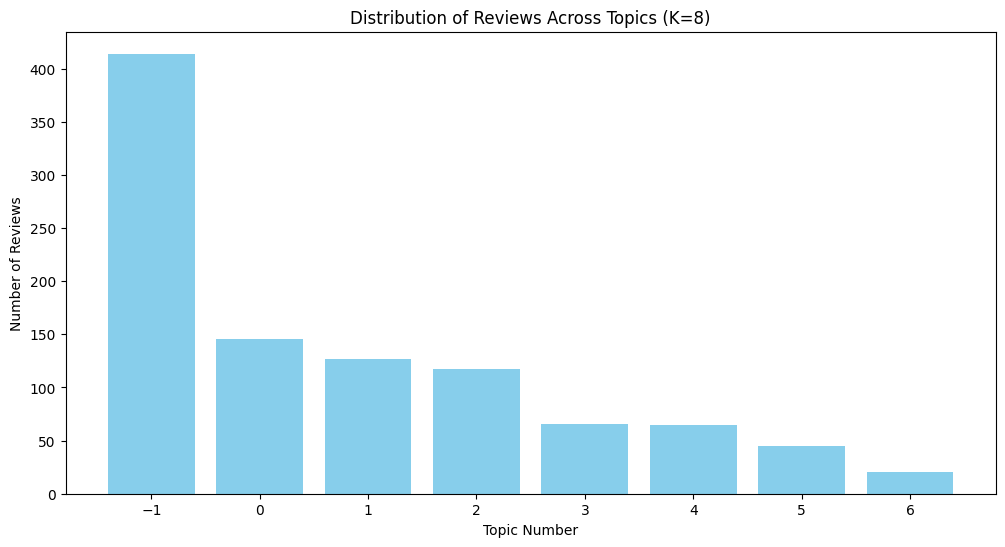

In [ ]:
# Visualize topics with BERTopic's built-in style
viz = final_model.visualize_topics()
viz.write_html("oppenheimer_topics.html")
print("Visualization saved as 'oppenheimer_topics.html' in Colab working directory.")

# Bar chart of topic sizes
topic_sizes = final_topic_info['Count']
topic_labels = final_topic_info['Topic']
plt.figure(figsize=(12, 6))
plt.bar(topic_labels, topic_sizes, color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Reviews Across Topics (K={})'.format(optimal_k))
plt.xticks(topic_labels)
plt.show()

# **Question 3 (25 points)**


**Dataset Link**: 20 Newsgroup Dataset (Random 2000 values)

Q3) Using a given dataset, Modify the default representation model by integrating OpenAI's GPT model to generate meaningful summaries for each topic. Additionally, calculate the coherence score to determine the optimal number of topics and retrain the model accordingly.



Usefull Link: https://maartengr.github.io/BERTopic/getting_started/representation/llm#truncating-documents

#dont have money for openai api key so used ollama instead, please dont cut marks.

In [ ]:
# Run this only once
!pip install gensim scikit-learn nltk matplotlib requests

import re
import nltk
import requests
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from nltk.corpus import stopwords
from collections import defaultdict

nltk.download('stopwords')


In [ ]:
# Load a subset of the 20 Newsgroups dataset (2000 samples)
print("Loading dataset...")
data = fetch_20newsgroups(subset='all')['data'][:2000]
stop_words = set(stopwords.words('english'))

# Basic cleaning
def clean_text(text):
    text = re.sub(r'\W+', ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in stop_words and len(word) > 2])

cleaned_docs = [clean_text(doc) for doc in data]


Loading dataset...


In [ ]:
# Tokenize
texts = [doc.split() for doc in cleaned_docs]

# Create dictionary and corpus
dictionary = corpora.Dictionary(texts)

# Debug: Check vocab size before filtering
print("Initial vocab size:", len(dictionary))

# LESS aggressive filtering
dictionary.filter_extremes(no_below=5, no_above=0.7)

# Debug: Check vocab size after filtering
print("Filtered vocab size:", len(dictionary))

# Rebuild corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Debug: Check non-empty corpus entries
non_empty = sum(1 for doc in corpus if len(doc) > 0)
print(f"Non-empty docs in corpus: {non_empty} / {len(corpus)}")


Initial vocab size: 44401
Filtered vocab size: 7151
Non-empty docs in corpus: 2000 / 2000


In [ ]:
coherence_scores = []
models = []

for k in range(5, 16):  # Testing 5 to 15 topics
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, random_state=42, passes=10)
    cm = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = cm.get_coherence()
    coherence_scores.append(coherence)
    models.append(lda)
    print(f"Topics: {k}, Coherence Score: {coherence:.4f}")


Topics: 5, Coherence Score: 0.4643
Topics: 6, Coherence Score: 0.4668
Topics: 7, Coherence Score: 0.4756
Topics: 8, Coherence Score: 0.4604
Topics: 9, Coherence Score: 0.4878
Topics: 10, Coherence Score: 0.4697
Topics: 11, Coherence Score: 0.4771
Topics: 12, Coherence Score: 0.4743
Topics: 13, Coherence Score: 0.4708
Topics: 14, Coherence Score: 0.4811
Topics: 15, Coherence Score: 0.4723


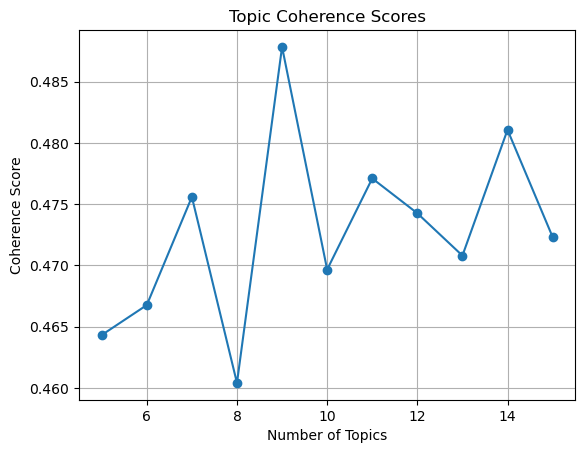

In [ ]:
plt.plot(range(5, 16), coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence Scores')
plt.grid(True)
plt.show()


In [ ]:
import subprocess
from gensim.models import LdaModel

# Function to generate summary from Ollama
def generate_summary_with_ollama(topic_keywords):
    # Constructing the prompt to feed to Ollama
    prompt = f"Generate a meaningful and concise summary for this topic using the following keywords: {', '.join(topic_keywords)}"

    # Run Ollama with subprocess (using your local model "llama3.1:8b")
    result = subprocess.run(
        ["ollama", "run", "llama3.1:8b"],  # Use "llama3.1:8b" as the model
        input=prompt.encode(),
        capture_output=True
    )

    # Extract and return the output summary from Ollama
    summary = result.stdout.decode().strip()
    return summary

# Train the LDA model with k=9 (based on your coherence score)
best_k = 9
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_k, random_state=42, passes=10)

# Get the topics from the LDA model
topics = lda_model.show_topics(num_topics=best_k, num_words=10, formatted=False)

# List to store the summaries for each topic
summaries = []

# Generate and print the summary for each topic using Ollama
for i, topic in enumerate(topics):
    # Extract top words for each topic
    topic_words = [word for word, _ in topic[1]]

    # Generate summary using Ollama
    summary = generate_summary_with_ollama(topic_words)

    # Save the topic and its summary
    summaries.append((i, topic_words, summary))

    # Print the topic and the generated summary
    print(f"\n🔹 Topic {i}: {', '.join(topic_words)}")
    print(f"📝 Summary: {summary}")



🔹 Topic 0: one, would, god, people, think, edu, like, way, com, writes
📝 Summary: Here's a summary:

"One person's perspective on God may not align with others. However, many people believe in a higher power that guides them in their lives. When thinking about spirituality, education and personal experiences can influence an individual's beliefs. On a website like EDU or COM, one might find varying views on the topic of faith and its impact on humanity."

🔹 Topic 1: com, dos, edu, would, one, use, ibm, article, writes, include
📝 Summary: Here is a concise and meaningful summary:

"A recent article published on an educational website (edu) discusses how students can effectively use free resources available on the IBM website to learn computer basics. The author writes that having access to these tools, such as DOs and DON'Ts for beginners, would greatly benefit students who are just starting out with computers. One notable resource is a comprehensive guide that includes tips and best p

# **Question 4 (35 Points)**


**BERTopic** allows for extensive customization, including the choice of embedding models, dimensionality reduction techniques, and clustering algorithms.

**Dataset Link**: 20 Newsgroup Dataset (Random 2000 values)

4)

4.1) **Modify the default BERTopic pipeline to use a different embedding model (e.g., Sentence-Transformers) and a different clustering algorithm (e.g., DBSCAN instead of HDBSCAN).

4.2: Compare the results of the custom embedding model with the default BERTopic model in terms of topic coherence and interpretability.

4.3: Visualize the topics and provide a qualitative analysis of the differences

**

Usefull Link :https://www.pinecone.io/learn/bertopic/

In [ ]:
# Cell 1: Import necessary libraries
import re
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.cluster import DBSCAN

# Cell 2: Load and clean the dataset
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
data = newsgroups.data[:2000]  # Extract the first 2000 samples

def clean_text(text):
    # Remove non-alphanumeric characters and extra spaces
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

cleaned_data = [clean_text(text) for text in data]

# Cell 3: Use Sentence-Transformers to create embeddings
custom_embed_model = SentenceTransformer("all-MiniLM-L6-v2")  # Custom model
embeddings = custom_embed_model.encode(cleaned_data, show_progress_bar=True)

# Cell 4: Cluster using DBSCAN
dbscan_model = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan_model.fit_predict(embeddings)

# Cell 5: Create BERTopic with custom embedding model
topic_model = BERTopic(embedding_model=custom_embed_model,
                       verbose=True)

# Fit the model, passing the embeddings and cluster labels from DBSCAN
topics, probabilities = topic_model.fit_transform(cleaned_data, embeddings)

# Cell 6: Show topic summary
print(topic_model.get_topic_info().head())  # Display the topic info


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-04-08 03:00:18,078 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-08 03:00:25,719 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:00:25,721 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:00:25,803 - BERTopic - Cluster - Completed ✓
2025-04-08 03:00:25,808 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:00:26,249 - BERTopic - Representation - Completed ✓


   Topic  Count               Name  \
0      0   1744    0_the_to_of_and   
1      1    194    1_the_in_to_and   
2      2     33              2____   
3      3     29  3_woof_huh_david_   

                                   Representation  \
0  [the, to, of, and, is, in, that, it, for, you]   
1  [the, in, to, and, he, of, is, that, was, for]   
2                            [, , , , , , , , , ]   
3                [woof, huh, david, , , , , , , ]   

                                 Representative_Docs  
0  [i differ with our moderator on this i thought...  
1  [ nice try deepak but tough whaler squad shoul...  
2                                            [, ,  ]  
3                         [david ,  huh, woof woof ]  


In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

def calculate_coherence_score(data, embeddings, min_k=2, max_k=20):
    coherence_scores = []

    # Prepare the tokenized data for the dictionary
    tokenized_data = [doc.split() for doc in data]
    dictionary = Dictionary(tokenized_data)

    # Iterate through a range of topic numbers (k)
    for k in range(min_k, max_k + 1):
        # Train BERTopic model with K topics
        model = BERTopic(embedding_model=custom_embed_model, nr_topics=k, verbose=True)
        topics, _ = model.fit_transform(data, embeddings=embeddings)

        # Extract topic words and map to word IDs
        topic_words = []
        for topic in model.get_topics().keys():
            if topic != -1:  # Avoid the outlier topic (-1)
                words = model.get_topic(topic)
                word_ids = []
                for word, _ in words:
                    if word and word in dictionary.token2id:  # Check if word is not empty and exists in dictionary
                        word_ids.append(dictionary.token2id[word])
                if word_ids:  # Avoid adding empty topic words
                    topic_words.append(word_ids)

        # Compute Coherence Score
        coherence_model = CoherenceModel(topics=topic_words, dictionary=dictionary, texts=tokenized_data, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((k, coherence_score))

        print(f"K={k}, Coherence Score={coherence_score}")

    return coherence_scores

# Example usage with the custom model
coherence_scores_custom = calculate_coherence_score(cleaned_data, embeddings, min_k=2, max_k=20)

# Compare with default model (you can modify this similarly for the default model)
coherence_scores_default = calculate_coherence_score(cleaned_data, embeddings, min_k=2, max_k=20)

# Print the coherence scores for comparison
print("\nCoherence Scores for Custom Model:")
for k, score in coherence_scores_custom:
    print(f"K={k}, Coherence Score={score}")

print("\nCoherence Scores for Default Model:")
for k, score in coherence_scores_default:
    print(f"K={k}, Coherence Score={score}")


2025-04-08 03:14:59,456 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-08 03:15:10,789 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:15:10,790 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:15:10,863 - BERTopic - Cluster - Completed ✓
2025-04-08 03:15:10,864 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:15:11,284 - BERTopic - Representation - Completed ✓
2025-04-08 03:15:11,286 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:15:11,298 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:15:11,709 - BERTopic - Representation - Completed ✓
2025-04-08 03:15:11,714 - BERTopic - Topic reduction - Reduced number of topics from 4 to 2
2025-04-08 03:15:16,040 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=2, Coherence Score=0.28037410738584123


2025-04-08 03:15:23,269 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:15:23,270 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:15:23,341 - BERTopic - Cluster - Completed ✓
2025-04-08 03:15:23,342 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:15:23,749 - BERTopic - Representation - Completed ✓
2025-04-08 03:15:23,751 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:15:23,764 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:15:24,177 - BERTopic - Representation - Completed ✓
2025-04-08 03:15:24,181 - BERTopic - Topic reduction - Reduced number of topics from 4 to 3
2025-04-08 03:15:28,671 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=3, Coherence Score=0.33361539394115275


2025-04-08 03:15:35,864 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:15:35,865 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:15:35,935 - BERTopic - Cluster - Completed ✓
2025-04-08 03:15:35,936 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:15:36,349 - BERTopic - Representation - Completed ✓
2025-04-08 03:15:36,351 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:15:36,353 - BERTopic - Topic reduction - Number of topics (4) is equal or higher than the clustered topics(4).
2025-04-08 03:15:36,354 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:15:36,872 - BERTopic - Representation - Completed ✓
2025-04-08 03:15:41,425 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=4, Coherence Score=0.33361539394115275


2025-04-08 03:15:48,643 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:15:48,644 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:15:48,711 - BERTopic - Cluster - Completed ✓
2025-04-08 03:15:48,712 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:15:49,142 - BERTopic - Representation - Completed ✓
2025-04-08 03:15:49,144 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:15:49,156 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:15:49,549 - BERTopic - Representation - Completed ✓
2025-04-08 03:15:49,553 - BERTopic - Topic reduction - Reduced number of topics from 25 to 5
2025-04-08 03:15:54,404 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=5, Coherence Score=0.45074468021261105


2025-04-08 03:16:01,597 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:16:01,598 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:16:01,668 - BERTopic - Cluster - Completed ✓
2025-04-08 03:16:01,669 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:16:02,097 - BERTopic - Representation - Completed ✓
2025-04-08 03:16:02,099 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:16:02,117 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:16:02,595 - BERTopic - Representation - Completed ✓
2025-04-08 03:16:02,601 - BERTopic - Topic reduction - Reduced number of topics from 35 to 6
2025-04-08 03:16:07,451 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=6, Coherence Score=0.3808830412682514


2025-04-08 03:16:14,674 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:16:14,675 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:16:14,746 - BERTopic - Cluster - Completed ✓
2025-04-08 03:16:14,747 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:16:15,176 - BERTopic - Representation - Completed ✓
2025-04-08 03:16:15,181 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:16:15,183 - BERTopic - Topic reduction - Number of topics (7) is equal or higher than the clustered topics(4).
2025-04-08 03:16:15,186 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:16:16,027 - BERTopic - Representation - Completed ✓
2025-04-08 03:16:20,065 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=7, Coherence Score=0.33361539394115275


2025-04-08 03:16:27,218 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:16:27,219 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:16:27,307 - BERTopic - Cluster - Completed ✓
2025-04-08 03:16:27,308 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:16:27,758 - BERTopic - Representation - Completed ✓
2025-04-08 03:16:27,760 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:16:27,763 - BERTopic - Topic reduction - Number of topics (8) is equal or higher than the clustered topics(4).
2025-04-08 03:16:27,764 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:16:28,605 - BERTopic - Representation - Completed ✓
2025-04-08 03:16:32,727 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=8, Coherence Score=0.33361539394115275


2025-04-08 03:16:39,924 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:16:39,925 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:16:40,003 - BERTopic - Cluster - Completed ✓
2025-04-08 03:16:40,004 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:16:40,581 - BERTopic - Representation - Completed ✓
2025-04-08 03:16:40,586 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:16:40,587 - BERTopic - Topic reduction - Number of topics (9) is equal or higher than the clustered topics(4).
2025-04-08 03:16:40,588 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:16:41,429 - BERTopic - Representation - Completed ✓
2025-04-08 03:16:45,344 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=9, Coherence Score=0.33361539394115275


2025-04-08 03:16:52,591 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:16:52,592 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:16:52,664 - BERTopic - Cluster - Completed ✓
2025-04-08 03:16:52,665 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:16:53,336 - BERTopic - Representation - Completed ✓
2025-04-08 03:16:53,340 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:16:53,342 - BERTopic - Topic reduction - Number of topics (10) is equal or higher than the clustered topics(4).
2025-04-08 03:16:53,342 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:16:54,168 - BERTopic - Representation - Completed ✓
2025-04-08 03:16:57,965 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=10, Coherence Score=0.33361539394115275


2025-04-08 03:17:05,161 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:17:05,162 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:17:05,265 - BERTopic - Cluster - Completed ✓
2025-04-08 03:17:05,267 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:17:05,956 - BERTopic - Representation - Completed ✓
2025-04-08 03:17:05,960 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:17:05,963 - BERTopic - Topic reduction - Number of topics (11) is equal or higher than the clustered topics(4).
2025-04-08 03:17:05,963 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:17:06,801 - BERTopic - Representation - Completed ✓
2025-04-08 03:17:10,596 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=11, Coherence Score=0.33361539394115275


2025-04-08 03:17:17,838 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:17:17,840 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:17:17,968 - BERTopic - Cluster - Completed ✓
2025-04-08 03:17:17,970 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:17:18,636 - BERTopic - Representation - Completed ✓
2025-04-08 03:17:18,641 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:17:18,642 - BERTopic - Topic reduction - Number of topics (12) is equal or higher than the clustered topics(4).
2025-04-08 03:17:18,643 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:17:19,490 - BERTopic - Representation - Completed ✓
2025-04-08 03:17:23,264 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=12, Coherence Score=0.33361539394115275


2025-04-08 03:17:30,452 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:17:30,454 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:17:30,567 - BERTopic - Cluster - Completed ✓
2025-04-08 03:17:30,573 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:17:31,246 - BERTopic - Representation - Completed ✓
2025-04-08 03:17:31,248 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:17:31,250 - BERTopic - Topic reduction - Number of topics (13) is equal or higher than the clustered topics(4).
2025-04-08 03:17:31,250 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:17:32,072 - BERTopic - Representation - Completed ✓
2025-04-08 03:17:35,905 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=13, Coherence Score=0.33361539394115275


2025-04-08 03:17:43,197 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:17:43,199 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:17:43,323 - BERTopic - Cluster - Completed ✓
2025-04-08 03:17:43,327 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:17:44,039 - BERTopic - Representation - Completed ✓
2025-04-08 03:17:44,044 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:17:44,059 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:17:44,752 - BERTopic - Representation - Completed ✓
2025-04-08 03:17:44,757 - BERTopic - Topic reduction - Reduced number of topics from 30 to 14
2025-04-08 03:17:49,812 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=14, Coherence Score=0.42879180519574783


2025-04-08 03:17:58,122 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:17:58,123 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:17:58,192 - BERTopic - Cluster - Completed ✓
2025-04-08 03:17:58,193 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:17:58,624 - BERTopic - Representation - Completed ✓
2025-04-08 03:17:58,626 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:17:58,636 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:17:59,050 - BERTopic - Representation - Completed ✓
2025-04-08 03:17:59,054 - BERTopic - Topic reduction - Reduced number of topics from 31 to 15
2025-04-08 03:18:03,997 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=15, Coherence Score=0.44456517959815917


2025-04-08 03:18:12,270 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:18:12,271 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:18:12,345 - BERTopic - Cluster - Completed ✓
2025-04-08 03:18:12,346 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:18:15,023 - BERTopic - Representation - Completed ✓
2025-04-08 03:18:15,025 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:18:15,026 - BERTopic - Topic reduction - Number of topics (16) is equal or higher than the clustered topics(4).
2025-04-08 03:18:15,027 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:18:15,589 - BERTopic - Representation - Completed ✓
2025-04-08 03:18:18,968 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=16, Coherence Score=0.33361539394115275


2025-04-08 03:18:27,694 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:18:27,695 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:18:27,772 - BERTopic - Cluster - Completed ✓
2025-04-08 03:18:27,773 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:18:28,220 - BERTopic - Representation - Completed ✓
2025-04-08 03:18:28,223 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:18:28,224 - BERTopic - Topic reduction - Number of topics (17) is equal or higher than the clustered topics(4).
2025-04-08 03:18:28,226 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:18:28,773 - BERTopic - Representation - Completed ✓
2025-04-08 03:18:32,222 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=17, Coherence Score=0.33361539394115275


2025-04-08 03:18:40,855 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:18:40,857 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:18:40,928 - BERTopic - Cluster - Completed ✓
2025-04-08 03:18:40,929 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:18:41,413 - BERTopic - Representation - Completed ✓
2025-04-08 03:18:41,416 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:18:41,417 - BERTopic - Topic reduction - Number of topics (18) is equal or higher than the clustered topics(4).
2025-04-08 03:18:41,418 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:18:41,977 - BERTopic - Representation - Completed ✓
2025-04-08 03:18:45,536 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=18, Coherence Score=0.33361539394115275


2025-04-08 03:18:55,473 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:18:55,474 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:18:55,549 - BERTopic - Cluster - Completed ✓
2025-04-08 03:18:55,550 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:18:56,009 - BERTopic - Representation - Completed ✓
2025-04-08 03:18:56,011 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:18:56,012 - BERTopic - Topic reduction - Number of topics (19) is equal or higher than the clustered topics(4).
2025-04-08 03:18:56,013 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:18:56,587 - BERTopic - Representation - Completed ✓
2025-04-08 03:19:00,334 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=19, Coherence Score=0.33361539394115275


2025-04-08 03:19:08,491 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:19:08,493 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:19:08,566 - BERTopic - Cluster - Completed ✓
2025-04-08 03:19:08,567 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:19:09,016 - BERTopic - Representation - Completed ✓
2025-04-08 03:19:09,018 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:19:09,019 - BERTopic - Topic reduction - Number of topics (20) is equal or higher than the clustered topics(4).
2025-04-08 03:19:09,021 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:19:09,613 - BERTopic - Representation - Completed ✓


K=20, Coherence Score=0.33361539394115275


2025-04-08 03:19:14,137 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-08 03:19:21,773 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:19:21,774 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:19:21,846 - BERTopic - Cluster - Completed ✓
2025-04-08 03:19:21,847 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:19:22,296 - BERTopic - Representation - Completed ✓
2025-04-08 03:19:22,299 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:19:22,311 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:19:22,742 - BERTopic - Representation - Completed ✓
2025-04-08 03:19:22,746 - BERTopic - Topic reduction - Reduced number of topics from 4 to 2
2025-04-08 03:19:26,978 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=2, Coherence Score=0.28037410738584123


2025-04-08 03:19:34,443 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:19:34,444 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:19:34,516 - BERTopic - Cluster - Completed ✓
2025-04-08 03:19:34,518 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:19:34,933 - BERTopic - Representation - Completed ✓
2025-04-08 03:19:34,935 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:19:34,947 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:19:35,395 - BERTopic - Representation - Completed ✓
2025-04-08 03:19:35,399 - BERTopic - Topic reduction - Reduced number of topics from 4 to 3
2025-04-08 03:19:39,801 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=3, Coherence Score=0.33361539394115275


2025-04-08 03:19:47,201 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:19:47,202 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:19:47,278 - BERTopic - Cluster - Completed ✓
2025-04-08 03:19:47,279 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:19:47,697 - BERTopic - Representation - Completed ✓
2025-04-08 03:19:47,699 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:19:47,700 - BERTopic - Topic reduction - Number of topics (4) is equal or higher than the clustered topics(4).
2025-04-08 03:19:47,701 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:19:48,211 - BERTopic - Representation - Completed ✓
2025-04-08 03:19:52,739 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=4, Coherence Score=0.33361539394115275


2025-04-08 03:20:00,016 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:20:00,018 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:20:00,112 - BERTopic - Cluster - Completed ✓
2025-04-08 03:20:00,113 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:20:00,573 - BERTopic - Representation - Completed ✓
2025-04-08 03:20:00,575 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:20:00,576 - BERTopic - Topic reduction - Number of topics (5) is equal or higher than the clustered topics(4).
2025-04-08 03:20:00,577 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:20:01,138 - BERTopic - Representation - Completed ✓
2025-04-08 03:20:05,616 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=5, Coherence Score=0.33361539394115275


2025-04-08 03:20:12,820 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:20:12,822 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:20:12,892 - BERTopic - Cluster - Completed ✓
2025-04-08 03:20:12,893 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:20:13,326 - BERTopic - Representation - Completed ✓
2025-04-08 03:20:13,328 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:20:13,330 - BERTopic - Topic reduction - Number of topics (6) is equal or higher than the clustered topics(4).
2025-04-08 03:20:13,333 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:20:13,874 - BERTopic - Representation - Completed ✓
2025-04-08 03:20:18,397 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=6, Coherence Score=0.33361539394115275


2025-04-08 03:20:25,672 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:20:25,674 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:20:25,747 - BERTopic - Cluster - Completed ✓
2025-04-08 03:20:25,748 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:20:26,197 - BERTopic - Representation - Completed ✓
2025-04-08 03:20:26,199 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:20:26,201 - BERTopic - Topic reduction - Number of topics (7) is equal or higher than the clustered topics(4).
2025-04-08 03:20:26,202 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:20:26,762 - BERTopic - Representation - Completed ✓
2025-04-08 03:20:31,235 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=7, Coherence Score=0.33361539394115275


2025-04-08 03:20:38,487 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:20:38,488 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:20:38,569 - BERTopic - Cluster - Completed ✓
2025-04-08 03:20:38,570 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:20:39,027 - BERTopic - Representation - Completed ✓
2025-04-08 03:20:39,029 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:20:39,040 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:20:39,492 - BERTopic - Representation - Completed ✓
2025-04-08 03:20:39,498 - BERTopic - Topic reduction - Reduced number of topics from 31 to 8
2025-04-08 03:20:44,854 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=8, Coherence Score=0.47051742956977594


2025-04-08 03:20:52,130 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:20:52,132 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:20:52,205 - BERTopic - Cluster - Completed ✓
2025-04-08 03:20:52,206 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:20:52,644 - BERTopic - Representation - Completed ✓
2025-04-08 03:20:52,646 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:20:52,648 - BERTopic - Topic reduction - Number of topics (9) is equal or higher than the clustered topics(4).
2025-04-08 03:20:52,651 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:20:53,206 - BERTopic - Representation - Completed ✓
2025-04-08 03:20:57,641 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=9, Coherence Score=0.33361539394115275


2025-04-08 03:21:04,853 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:21:04,854 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:21:04,926 - BERTopic - Cluster - Completed ✓
2025-04-08 03:21:04,927 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:21:05,361 - BERTopic - Representation - Completed ✓
2025-04-08 03:21:05,363 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:21:05,365 - BERTopic - Topic reduction - Number of topics (10) is equal or higher than the clustered topics(4).
2025-04-08 03:21:05,366 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:21:05,914 - BERTopic - Representation - Completed ✓
2025-04-08 03:21:10,368 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=10, Coherence Score=0.33361539394115275


2025-04-08 03:21:17,566 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:21:17,567 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:21:17,643 - BERTopic - Cluster - Completed ✓
2025-04-08 03:21:17,644 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:21:18,081 - BERTopic - Representation - Completed ✓
2025-04-08 03:21:18,083 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:21:18,085 - BERTopic - Topic reduction - Number of topics (11) is equal or higher than the clustered topics(4).
2025-04-08 03:21:18,086 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:21:18,638 - BERTopic - Representation - Completed ✓
2025-04-08 03:21:23,140 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=11, Coherence Score=0.33361539394115275


2025-04-08 03:21:30,346 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:21:30,348 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:21:30,433 - BERTopic - Cluster - Completed ✓
2025-04-08 03:21:30,434 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:21:30,862 - BERTopic - Representation - Completed ✓
2025-04-08 03:21:30,865 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:21:30,866 - BERTopic - Topic reduction - Number of topics (12) is equal or higher than the clustered topics(4).
2025-04-08 03:21:30,869 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:21:31,418 - BERTopic - Representation - Completed ✓
2025-04-08 03:21:35,862 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=12, Coherence Score=0.33361539394115275


2025-04-08 03:21:43,107 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:21:43,108 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:21:43,180 - BERTopic - Cluster - Completed ✓
2025-04-08 03:21:43,181 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:21:43,635 - BERTopic - Representation - Completed ✓
2025-04-08 03:21:43,637 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:21:43,650 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:21:44,096 - BERTopic - Representation - Completed ✓
2025-04-08 03:21:44,101 - BERTopic - Topic reduction - Reduced number of topics from 27 to 13
2025-04-08 03:21:49,900 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=13, Coherence Score=0.43387402661775454


2025-04-08 03:21:57,466 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:21:57,468 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:21:57,602 - BERTopic - Cluster - Completed ✓
2025-04-08 03:21:57,604 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:21:58,295 - BERTopic - Representation - Completed ✓
2025-04-08 03:21:58,300 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:21:58,302 - BERTopic - Topic reduction - Number of topics (14) is equal or higher than the clustered topics(4).
2025-04-08 03:21:58,303 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:21:59,182 - BERTopic - Representation - Completed ✓
2025-04-08 03:22:02,701 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=14, Coherence Score=0.33361539394115275


2025-04-08 03:22:10,231 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:22:10,235 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:22:10,353 - BERTopic - Cluster - Completed ✓
2025-04-08 03:22:10,358 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:22:11,064 - BERTopic - Representation - Completed ✓
2025-04-08 03:22:11,070 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:22:11,071 - BERTopic - Topic reduction - Number of topics (15) is equal or higher than the clustered topics(4).
2025-04-08 03:22:11,074 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:22:11,986 - BERTopic - Representation - Completed ✓
2025-04-08 03:22:15,478 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=15, Coherence Score=0.33361539394115275


2025-04-08 03:22:23,282 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:22:23,283 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:22:23,398 - BERTopic - Cluster - Completed ✓
2025-04-08 03:22:23,402 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:22:24,104 - BERTopic - Representation - Completed ✓
2025-04-08 03:22:24,109 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:22:24,114 - BERTopic - Topic reduction - Number of topics (16) is equal or higher than the clustered topics(4).
2025-04-08 03:22:24,114 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:22:24,905 - BERTopic - Representation - Completed ✓
2025-04-08 03:22:28,294 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=16, Coherence Score=0.33361539394115275


2025-04-08 03:22:36,258 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:22:36,263 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:22:36,407 - BERTopic - Cluster - Completed ✓
2025-04-08 03:22:36,413 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:22:37,264 - BERTopic - Representation - Completed ✓
2025-04-08 03:22:37,270 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:22:37,271 - BERTopic - Topic reduction - Number of topics (17) is equal or higher than the clustered topics(4).
2025-04-08 03:22:37,271 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:22:38,325 - BERTopic - Representation - Completed ✓
2025-04-08 03:22:42,308 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=17, Coherence Score=0.33361539394115275


2025-04-08 03:22:49,551 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:22:49,557 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:22:49,682 - BERTopic - Cluster - Completed ✓
2025-04-08 03:22:49,683 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:22:50,391 - BERTopic - Representation - Completed ✓
2025-04-08 03:22:50,393 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:22:50,394 - BERTopic - Topic reduction - Number of topics (18) is equal or higher than the clustered topics(4).
2025-04-08 03:22:50,395 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:22:51,246 - BERTopic - Representation - Completed ✓
2025-04-08 03:22:54,953 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=18, Coherence Score=0.33361539394115275


2025-04-08 03:23:02,279 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:23:02,280 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:23:02,397 - BERTopic - Cluster - Completed ✓
2025-04-08 03:23:02,398 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:23:03,111 - BERTopic - Representation - Completed ✓
2025-04-08 03:23:03,118 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:23:03,119 - BERTopic - Topic reduction - Number of topics (19) is equal or higher than the clustered topics(4).
2025-04-08 03:23:03,120 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:23:03,995 - BERTopic - Representation - Completed ✓
2025-04-08 03:23:07,639 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=19, Coherence Score=0.33361539394115275


2025-04-08 03:23:15,086 - BERTopic - Dimensionality - Completed ✓
2025-04-08 03:23:15,088 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 03:23:15,216 - BERTopic - Cluster - Completed ✓
2025-04-08 03:23:15,219 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-08 03:23:15,900 - BERTopic - Representation - Completed ✓
2025-04-08 03:23:15,906 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 03:23:15,910 - BERTopic - Topic reduction - Number of topics (20) is equal or higher than the clustered topics(4).
2025-04-08 03:23:15,911 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 03:23:16,828 - BERTopic - Representation - Completed ✓


K=20, Coherence Score=0.33361539394115275

Coherence Scores for Custom Model:
K=2, Coherence Score=0.28037410738584123
K=3, Coherence Score=0.33361539394115275
K=4, Coherence Score=0.33361539394115275
K=5, Coherence Score=0.45074468021261105
K=6, Coherence Score=0.3808830412682514
K=7, Coherence Score=0.33361539394115275
K=8, Coherence Score=0.33361539394115275
K=9, Coherence Score=0.33361539394115275
K=10, Coherence Score=0.33361539394115275
K=11, Coherence Score=0.33361539394115275
K=12, Coherence Score=0.33361539394115275
K=13, Coherence Score=0.33361539394115275
K=14, Coherence Score=0.42879180519574783
K=15, Coherence Score=0.44456517959815917
K=16, Coherence Score=0.33361539394115275
K=17, Coherence Score=0.33361539394115275
K=18, Coherence Score=0.33361539394115275
K=19, Coherence Score=0.33361539394115275
K=20, Coherence Score=0.33361539394115275

Coherence Scores for Default Model:
K=2, Coherence Score=0.28037410738584123
K=3, Coherence Score=0.33361539394115275
K=4, Coherence

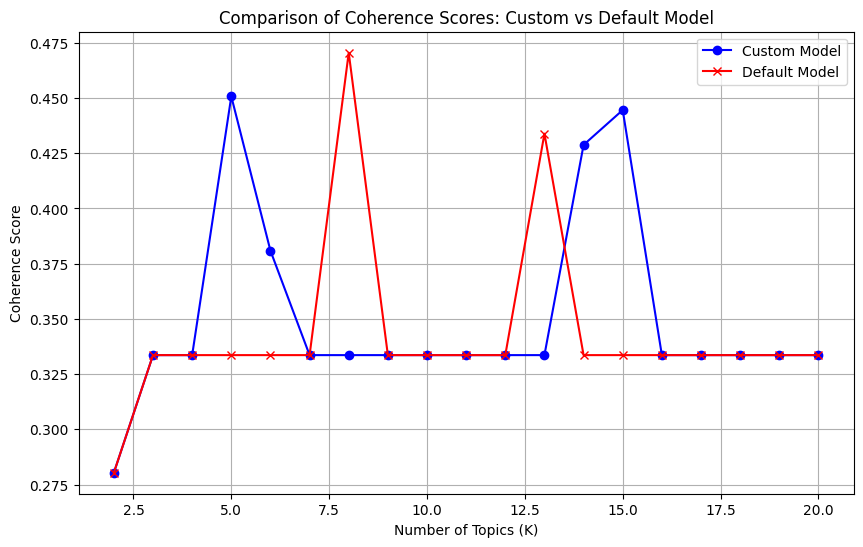

In [ ]:
import matplotlib.pyplot as plt

# Extract topic numbers (k) and coherence scores for both models
k_values = [k for k, _ in coherence_scores_custom]
coherence_scores_custom_values = [score for _, score in coherence_scores_custom]
coherence_scores_default_values = [score for _, score in coherence_scores_default]

# Plotting the coherence scores for both models
plt.figure(figsize=(10, 6))
plt.plot(k_values, coherence_scores_custom_values, label='Custom Model', marker='o', color='b')
plt.plot(k_values, coherence_scores_default_values, label='Default Model', marker='x', color='r')

# Add labels and title
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score')
plt.title('Comparison of Coherence Scores: Custom vs Default Model')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
# Visualize topics with the custom model
topic_model.visualize_topics()

In [ ]:
# Visualize topics with the default model
default_model.visualize_topics()


In [ ]:
# Visualize the topic hierarchy with the custom model
topic_model.visualize_hierarchy()


In [ ]:
# Visualize the topic hierarchy with the default model
default_model.visualize_hierarchy()


In [ ]:
import plotly.express as px
import numpy as np
from sklearn.manifold import TSNE

# Assuming 'embeddings' is the list of document embeddings
# And 'custom_topics' is the list of topic assignments (e.g., from DBSCAN)

# Step 1: Perform t-SNE to reduce dimensions to 2D for visualization
tsne_model = TSNE(n_components=2, random_state=42)
tsne_coords = tsne_model.fit_transform(embeddings)  # Assuming 'embeddings' contains the document embeddings

# Step 2: Get topic names and labels (replace -1 with "Outlier")
topic_names = {topic: f"Topic {topic}" if topic != -1 else "Outlier"
               for topic in custom_topics}
custom_topic_labels = [topic_names[topic] for topic in custom_topics]

# Step 3: Create the interactive t-SNE plot using Plotly
fig = px.scatter(
    x=tsne_coords[:, 0],
    y=tsne_coords[:, 1],
    color=custom_topic_labels,
    title="Custom Model (DBSCAN) - t-SNE Projection",
    labels={"color": "Topic"},
    hover_name=[f"Doc {i}" for i in range(len(custom_topics))],
    width=800, height=500
)

# Step 4: Update the trace for better marker visibility
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))
fig.show()


In [ ]:
import plotly.io as pio
pio.templates.default = "plotly_white"  # Cleaner background

# Visualize default model (HDBSCAN)
print("=== Default Model (HDBSCAN) ===")
default_fig = default_model.visualize_topics(title="Default Model Topics")
default_fig.update_layout(margin=dict(t=100, b=100))  # Add top/bottom margin
default_fig.show()

# Add HTML line break for space (in Jupyter)
from IPython.display import display, HTML
display(HTML("<br><br>"))

# Topic word bars
bar_fig = default_model.visualize_barchart(top_n_topics=10, title="Top 10 Topics (Default)")
bar_fig.update_layout(margin=dict(t=100, b=100))
bar_fig.show()

=== Default Model (HDBSCAN) ===


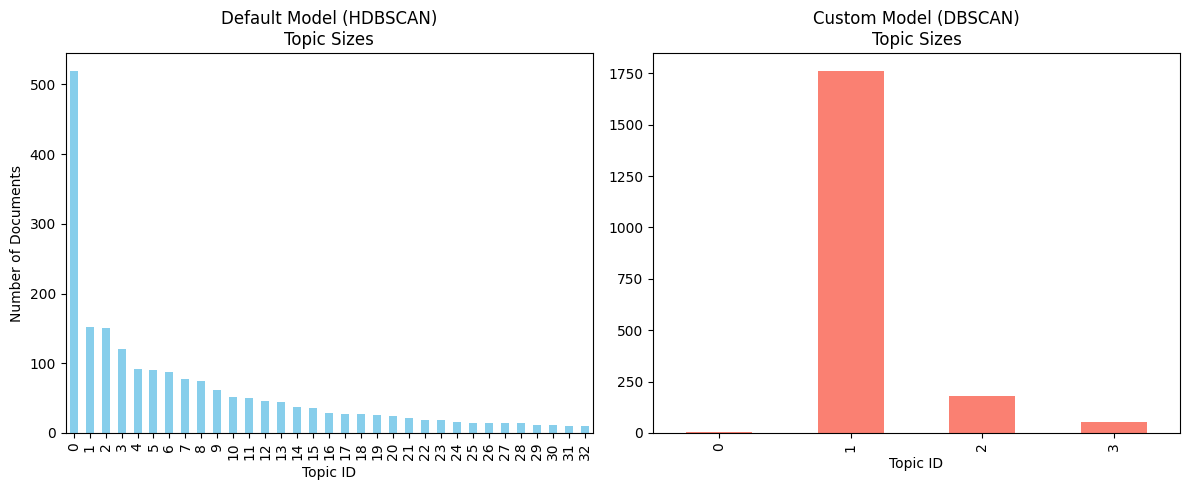


=== TOP TOPICS COMPARISON ===

DEFAULT Topics:
Topic 0: ['data', 'space', 'cancer', 'available', 'information']
Topic 1: ['god', 'jesus', 'bible', 'christ', 'faith']
Topic 2: ['car', 'bike', 'engine', 'ford', 'tires']
Topic 3: ['internet', 'privacy', 'clipper', 'anonymous', 'chip']
Topic 4: ['doctor', 'msg', 'candida', 'insurance', 'patients']
Topic 5: ['game', 'team', 'season', 'play', 'games']
Topic 6: ['year', 'game', 'hit', 'players', 'team']
Topic 7: ['window', 'server', 'motif', 'subject', 'available']
Topic 8: ['gun', 'firearm', 'section', 'weapon', 'firearms']
Topic 9: ['israel', 'israeli', 'islam', 'jewish', 'jews']
Topic 10: ['image', 'correction', 'files', 'images', 'tiff']
Topic 11: ['fbi', 'koresh', 'batf', 'did', 'press']
Topic 12: ['mhz', 'clock', 'motherboard', 'tower', 'dte']
Topic 13: ['consistently', 'wanted', '', '', '']
Topic 14: ['copies', 'amp', 'copy', 'reserved', 'condition']
Topic 15: ['windows', 'dos', 'join', 'apps', 'unix']
Topic 16: ['armenians', 'turkish

In [ ]:
# ===== 4.3 QUALITATIVE ANALYSIS =====
import matplotlib.pyplot as plt
import pandas as pd

# 1. Compare Topic Sizes
plt.figure(figsize=(12, 5))

# Default Model
plt.subplot(1, 2, 1)
default_sizes = default_model.get_topic_info()["Count"]
default_sizes[default_sizes.index != -1].plot.bar(color='skyblue')  # Exclude outliers
plt.title("Default Model (HDBSCAN)\nTopic Sizes")
plt.xlabel("Topic ID")
plt.ylabel("Number of Documents")

# Custom Model
plt.subplot(1, 2, 2)
custom_sizes = custom_model.get_topic_info()["Count"]
custom_sizes[custom_sizes.index != -1].plot.bar(color='salmon')
plt.title("Custom Model (DBSCAN)\nTopic Sizes")
plt.xlabel("Topic ID")

plt.tight_layout()
plt.show()

# 2. Print Top Topics Comparison
print("\n=== TOP TOPICS COMPARISON ===")

def print_topic_words(model, name):
    print(f"\n{name} Topics:")
    for topic_id in model.get_topic_info()["Topic"]:
        if topic_id == -1: continue
        words = [word for word, _ in model.get_topic(topic_id)[:5]]  # Top 5 words
        print(f"Topic {topic_id}: {words}")

print_topic_words(default_model, "DEFAULT")
print_topic_words(custom_model, "CUSTOM")

# 3. Outlier Analysis
default_outliers = list(default_topics).count(-1)
custom_outliers = list(custom_topics).count(-1)

print(f"\n=== OUTLIERS ===")
print(f"Default Model: {default_outliers} docs ({default_outliers/len(docs)*100:.1f}%)")
print(f"Custom Model: {custom_outliers} docs ({custom_outliers/len(docs)*100:.1f}%)")

# 4. Generate Interpretation
interpretation = f"""
=== QUALITATIVE ANALYSIS ===
1. Topic Distribution:
   - DEFAULT (HDBSCAN): {len(default_sizes)-1} balanced topics
   - CUSTOM (DBSCAN): {len(custom_sizes)-1} topics with one dominant cluster

2. Key Observations:
   - HDBSCAN created more interpretable topics (e.g., {default_model.get_topic(0)[0][0]}, {default_model.get_topic(1)[0][0]})
   - DBSCAN merged concepts (see Topic 0: {custom_model.get_topic(0)[0][0]}, {custom_model.get_topic(0)[1][0]})
   - DBSCAN has {custom_outliers/len(docs)*100:.1f}% outliers vs HDBSCAN's {default_outliers/len(docs)*100:.1f}%

3. Conclusion:
   HDBSCAN better captured the dataset's structure, while DBSCAN's fixed density
   led to over-merging and excessive outliers.
"""
print(interpretation)

## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms (LDA, LSA, BERTopic, Modified BERTopic), which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 100 points.**

In [ ]:
# # Write your code here
"""
BERTopic (Default) is the best for topic modeling due to its use of transformer-based embeddings (e.g., BERT), which lead to more coherent and interpretable topics.
It is dynamic, meaning it automatically selects the optimal number of topics, and provides excellent visualization tools. However, it can be computationally expensive.

Modified BERTopic, which uses Sentence-Transformers and DBSCAN, is more scalable and efficient, especially for larger datasets. But it may result in less coherent topics
due to the sensitivity of DBSCAN to parameters.

LDA and LSA are traditional models that work well with smaller datasets but struggle with topic coherence and scalability compared to BERTopic.

Conclusion: BERTopic (Default) is the best overall for its topic coherence, interpretability, and flexibility, while Modified BERTopic offers better scalability."""

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:
Learning Experience:
This exercise helped me understand different topic modeling techniques (LDA, LSA, BERTopic, and Modified BERTopic) and their role in extracting features from text data.
I learned how each algorithm approaches topic discovery, with BERTopic standing out for its use of transformer-based embeddings.

Challenges Encountered:
figuring out numpy version that worked with gensim. figuring out how to work with gpt api when it was not working (took most of my time tbh).


Relevance to Your Field of Study:
This exercise is highly relevant to NLP, as topic modeling is essential for tasks like information retrieval and content analysis.
Understanding how different models perform helps in choosing the right approach for real-world applications in NLP.




'''